# Notebook to make the graphs

## Reading the CSV files with the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step-by-step / No self-correction

metrics_step_no_corr = pd.read_csv("experiments\metrics_gpt-4o_2025-05-16T12-26-17.csv")

# Direct / No self-correction

metrics_direct_no_corr = pd.read_csv("experiments\metrics_gpt-4o_2025-05-18T22-05-45.csv")

# Step-by-step / Self-correction

metrics_step_corr = pd.read_csv("experiments\metrics_gpt-4o_2025-05-21T22-28-09.csv")

# Direct / Self-correction

metrics_direct_corr = pd.read_csv("experiments\metrics_gpt-4o_2025-05-19T17-10-43.csv")

## Making the graphs

### No self-correction

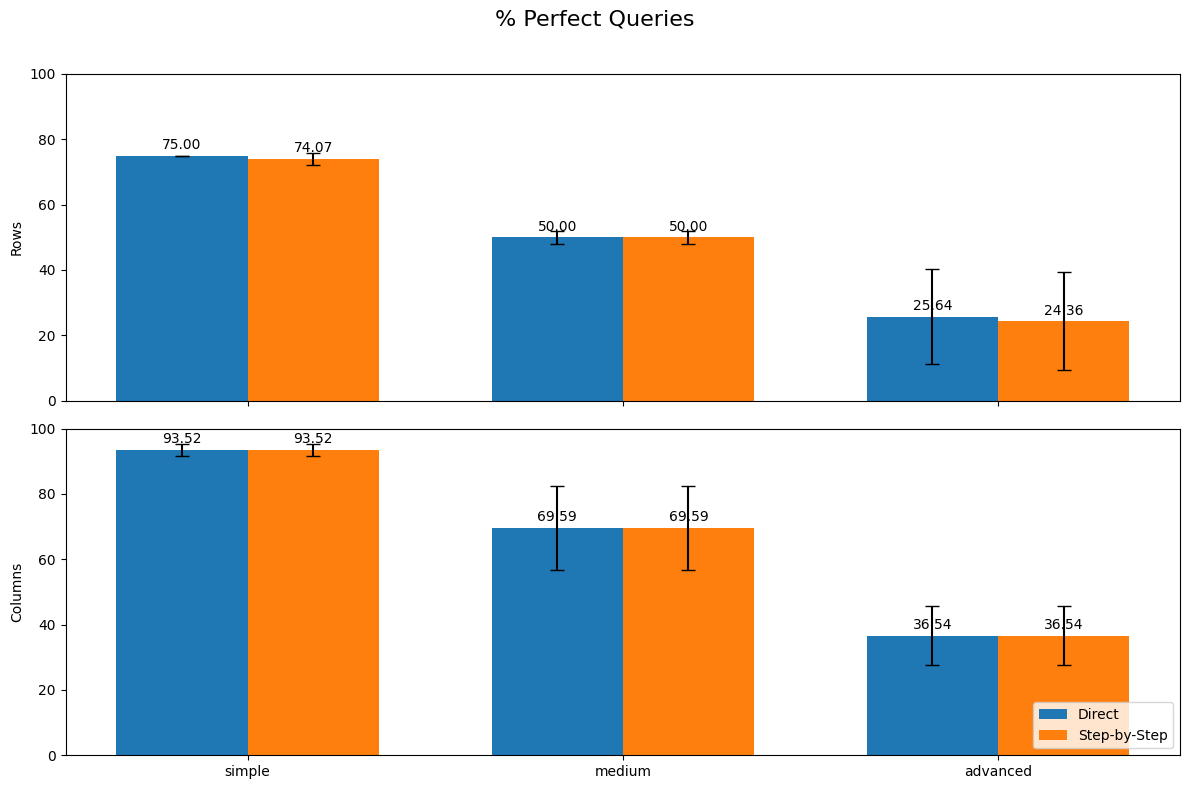

In [15]:
# Add prompt type before combining
metrics_direct_no_corr['prompt_type'] = 'Direct'
metrics_step_no_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_no_corr = metrics_direct_no_corr[metrics_direct_no_corr["query_run"] != 0]
metrics_step_no_corr = metrics_step_no_corr[metrics_step_no_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_no_corr, metrics_step_no_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:
    for prompt in ['Direct', 'Step-by-Step']:
        subset = df_all[(df_all['label'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_means = subset['N_perfect_row'].mean()
        row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        
        # ---- Columns ----
        col_means = subset['N_perfect_col'].mean()
        col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_means * 100,
            'std_row': row_stds * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_means * 100,
            'std_col': col_stds * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=16)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows")
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns")
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order)

# Legend
axs[1].legend(loc="lower right")

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### With self-correction

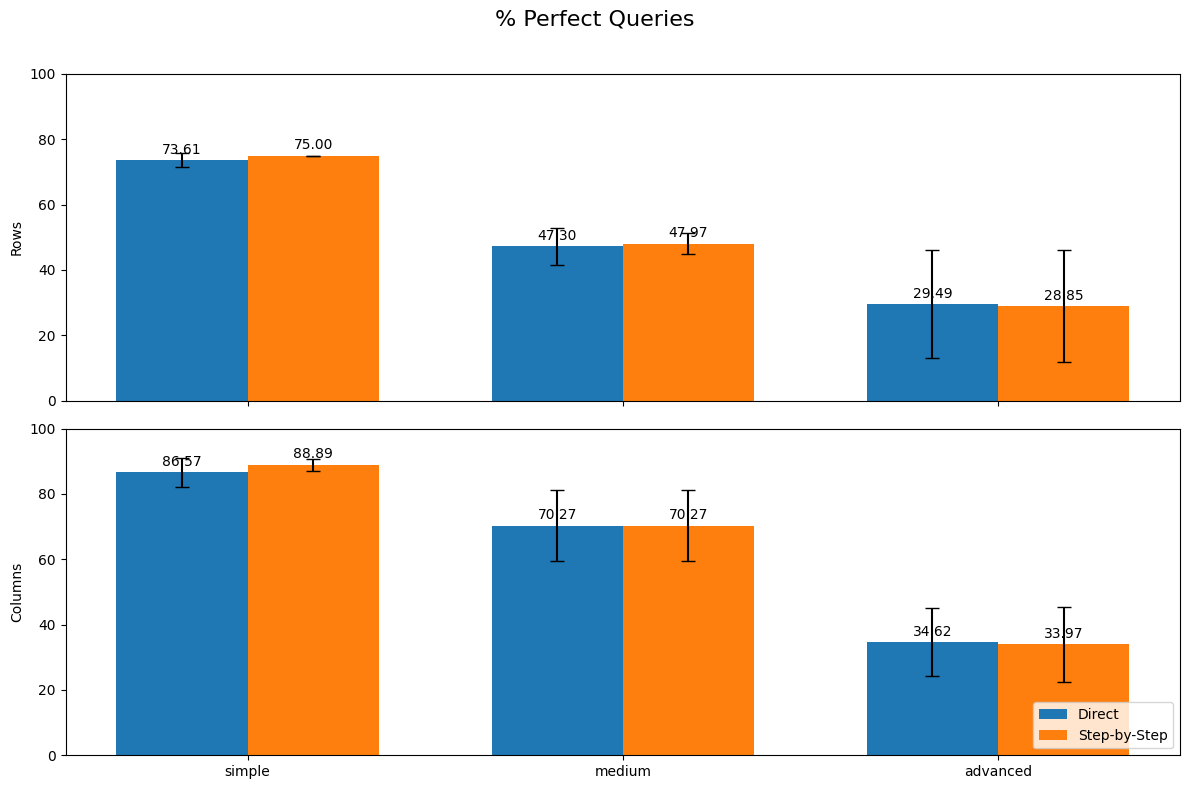

In [16]:
# Add prompt type before combining
metrics_direct_corr['prompt_type'] = 'Direct'
metrics_step_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_corr = metrics_direct_corr[metrics_direct_corr["query_run"] != 0]
metrics_step_corr = metrics_step_corr[metrics_step_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_corr, metrics_step_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:
    for prompt in ['Direct', 'Step-by-Step']:
        subset = df_all[(df_all['label'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_means = subset['N_perfect_row'].mean()
        row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        
        # ---- Columns ----
        col_means = subset['N_perfect_col'].mean()
        col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_means * 100,
            'std_row': row_stds * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_means * 100,
            'std_col': col_stds * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=16)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows")
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns")
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order)

# Legend
axs[1].legend(loc="lower right")

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()